**Task 1.1 - 1.3**

Training on Dataset A: The Adventures of Sherlock Holmes, by Arthur Conan Doyle

In [ ]:
# Setup and Imports:

import os, re, random, collections, math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.manifold import TSNE

import pickle
import json
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Reproducibility:
seed = 1337
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if device.type == 'cuda': torch.cuda.manual_seed_all(seed)

Device: cuda


In [ ]:
# Performing Vocabulary and Tokenization:

PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

# Cleaning:
def clean_natural_line(line):
    line = re.sub(r'[^a-zA-Z0-9 \.]', ' ', line)
    return line.lower()

# Tokenization:
def tokenize_natural(text):
    tokens = []
    for part in text.split():
        if part.endswith('.') and len(part) > 1:
            tokens.append(part[:-1]); tokens.append('.')
        else:
            tokens.append(part)
    return [t for t in tokens if t!='']

# Building Vocabulary:
def build_vocab(tokens, min_freq=1, max_vocab=None):
    freq = collections.Counter(tokens)
    items = [w for w,c in freq.most_common() if c>=min_freq]
    if max_vocab: items = items[:max_vocab]
    itos = [PAD_TOKEN, UNK_TOKEN] + items
    stoi = {w:i for i,w in enumerate(itos)}
    return stoi, itos, freq

# Tokens to IDs:
def tokens_to_ids(tokens, stoi):
    return [stoi.get(t, stoi[UNK_TOKEN]) for t in tokens]

# Creating Sliding Context Windows:
def sliding_context(tokens_ids, block_size):
    X, Y = [], []
    context = [0]*block_size
    for tid in tokens_ids:
        X.append(context.copy()); Y.append(tid)
        context = context[1:] + [tid]
    return np.array(X, dtype=np.int64), np.array(Y, dtype=np.int64)

In [ ]:
# Loading Dataset and Processing:

fname = "The adventure of sherlock holmes.txt"
assert os.path.exists(fname), f"Upload {fname} before running"

with open(fname, 'r', encoding='utf-8', errors='ignore') as f:
    raw = f.read()

tokens = tokenize_natural(clean_natural_line(raw))

# optional checking with a smaller sample
SAMPLE_LIMIT = None
if SAMPLE_LIMIT is not None:
    tokens = tokens[:SAMPLE_LIMIT]

stoi, itos, freq = build_vocab(tokens, min_freq=1)
print("Tokens:", len(tokens))
print("Vocabulary size (with PAD/UNK):", len(itos))
print("Top 10 tokens:", freq.most_common(10))
least10 = sorted(freq.items(), key=lambda x:(x[1], x[0]))[:10]
print("Least 10 tokens:", least10)

# Creating Sliding Context Windows:
block_size = 10
ids = tokens_to_ids(tokens, stoi)
X, Y = sliding_context(ids, block_size)
print("X shape:", X.shape, "Y shape:", Y.shape)


Tokens: 115383
Vocabulary size (with PAD/UNK): 8175
Top 10 tokens: [('.', 6333), ('the', 5822), ('and', 3085), ('i', 3038), ('to', 2826), ('of', 2781), ('a', 2697), ('in', 1826), ('that', 1767), ('it', 1749)]
Least 10 tokens: [('1.a', 1), ('1.b', 1), ('1.d', 1), ('1.e.2', 1), ('1.e.3', 1), ('1.e.4', 1), ('1.e.5', 1), ('1.e.6', 1), ('1.f', 1), ('1.f.1', 1)]
X shape: (115383, 10) Y shape: (115383,)


In [ ]:
# Dataset and Model Definitions:

class WordDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.Y = torch.tensor(Y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]

# Model Definition:
class NextWordMLP(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim=64,
                 hidden_sizes=[1024,1024], activation='tanh'):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        in_dim = block_size * emb_dim
        layers = []
        for hs in hidden_sizes:
            layers.append(nn.Linear(in_dim, hs))
            layers.append(nn.Tanh() if activation=='tanh' else nn.ReLU())
            in_dim = hs
        self.mlp = nn.Sequential(*layers)
        self.head = nn.Linear(in_dim, vocab_size)
    def forward(self, x):
        e = self.emb(x).view(x.size(0), -1)
        h = self.mlp(e)
        return self.head(h)


In [ ]:
# Training and Evaluation Functions:
def train_model(X, Y, itos, block_size, emb_dim, activation,
                batch_size=131072, epochs=200, lr=1e-3, val_frac=0.1):
    ds = WordDataset(X, Y)
    n_val = int(len(ds) * val_frac)
    train_ds, val_ds = random_split(ds, [len(ds)-n_val, n_val])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    model = NextWordMLP(block_size, len(itos), emb_dim=emb_dim,
                        hidden_sizes=[1024,1024], activation=activation).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_loss': []}
    for ep in range(1, epochs+1):
        model.train(); total, count = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            loss = loss_fn(model(xb), yb)
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item() * xb.size(0); count += xb.size(0)
        train_loss = total / count

        model.eval(); val_total, val_count = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_total += loss_fn(model(xb), yb).item() * xb.size(0)
                val_count += xb.size(0)
        val_loss = val_total / val_count
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if ep % 10 == 0 or ep <= 3:
            print(f"Epoch {ep}/{epochs} - Train {train_loss:.4f} | Val {val_loss:.4f}")
    return model, history

# Evaluation Function:
def compute_accuracy(model, X, Y):
    ds = WordDataset(X, Y)
    loader = DataLoader(ds, batch_size=512)
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=-1)
            correct += (preds == yb).sum().item()
            total += yb.numel()
    return correct / total


In [ ]:
# Text Generation and Visualization Functions:

def generate_from_prompt(model, itos, stoi, prompt, block_size=10, max_tokens=30, temp=1.0):
    model.eval()
    toks = tokenize_natural(prompt)
    ids = [stoi.get(t, stoi[UNK_TOKEN]) for t in toks]
    context = [0]*max(0, block_size - len(ids)) + ids[-block_size:]
    out = toks.copy()
    with torch.no_grad():
        for _ in range(max_tokens):
            x = torch.tensor([context], dtype=torch.long).to(device)
            logits = model(x)[0] / temp
            probs = F.softmax(logits, dim=-1).cpu().numpy()
            idx = np.random.choice(len(probs), p=probs)
            token = itos[idx]
            if token == PAD_TOKEN: break
            out.append(token)
            context = context[1:] + [idx]
    return " ".join(out)

# t-SNE Visualization:
def plot_tsne_for_model(model, itos, select_tokens=None, title='t-SNE Embeddings', perplexity=30):
    emb = model.emb.weight.detach().cpu().numpy()
    if emb.shape[0] > 5000:
        emb = emb[:2000]; labels = itos[:2000]
    else:
        labels = itos
    print("Running t-SNE on", len(labels), "tokens...")
    tsne = TSNE(n_components=2, random_state=seed, perplexity=min(perplexity, 50))
    emb2 = tsne.fit_transform(emb)
    plt.figure(figsize=(10,8))
    plt.scatter(emb2[:,0], emb2[:,1], s=6, alpha=0.6)
    for i in range(2, min(102, len(labels))): plt.text(emb2[i,0], emb2[i,1], labels[i], fontsize=8)
    plt.title(title); plt.show()



[1/8] Training emb_dim=64, activation=relu, block_size=5
Epoch 1/500 - Train 9.0103 | Val 8.6270
Epoch 2/500 - Train 8.6219 | Val 8.0401
Epoch 3/500 - Train 8.0307 | Val 7.2445
Epoch 10/500 - Train 6.3977 | Val 6.4452
Epoch 20/500 - Train 6.1537 | Val 6.3149
Epoch 30/500 - Train 5.9237 | Val 6.1620
Epoch 40/500 - Train 5.6795 | Val 6.0390
Epoch 50/500 - Train 5.3639 | Val 5.9412
Epoch 60/500 - Train 5.0072 | Val 5.9428
Epoch 70/500 - Train 4.6076 | Val 6.0509
Epoch 80/500 - Train 4.1420 | Val 6.2766
Epoch 90/500 - Train 3.6694 | Val 6.6185
Epoch 100/500 - Train 3.2777 | Val 6.9861
Epoch 110/500 - Train 2.9570 | Val 7.3285
Epoch 120/500 - Train 2.6951 | Val 7.6506
Epoch 130/500 - Train 2.4675 | Val 7.9483
Epoch 140/500 - Train 2.2677 | Val 8.2201
Epoch 150/500 - Train 2.0850 | Val 8.4906
Epoch 160/500 - Train 1.9312 | Val 8.7562
Epoch 170/500 - Train 1.7937 | Val 8.9744
Epoch 180/500 - Train 1.6708 | Val 9.1989
Epoch 190/500 - Train 1.5279 | Val 9.3700
Epoch 200/500 - Train 1.3942 | Va

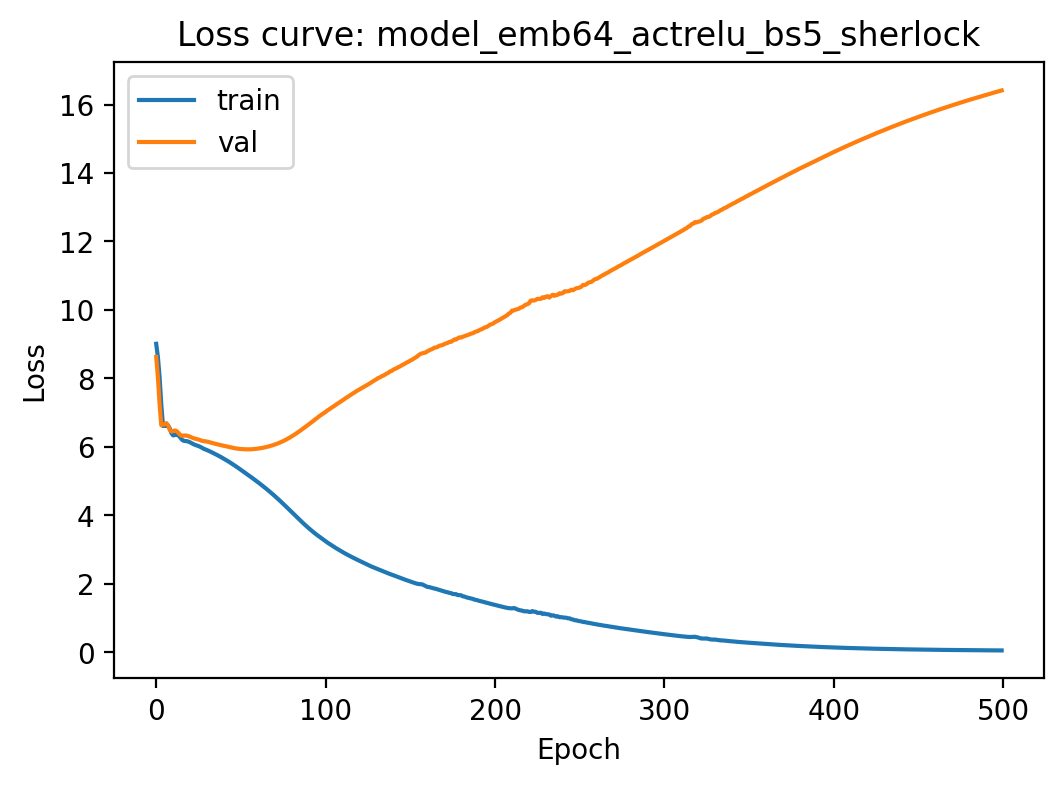

Training accuracy: 0.9021

Temperature 0.3:
Sherlock Holmes works to the other side of the west end . it may remember some little in this spirits . sherlock holmes was silent in his pew . it was headed that he might spend well . i am said that

Temperature 0.8:
Sherlock Holmes works to the other of the investigation which he closed keeping but his quietly . i shall just say time to you a turn which i have nothing in her due manner circle at the man said he . yes

Temperature 1.2:
Sherlock Holmes works to the other side of the road and the park . quite so said holmes that was a good deal . i did myself right and at england my hair before a man who entered a sedentary close with
Running t-SNE on 2000 tokens...


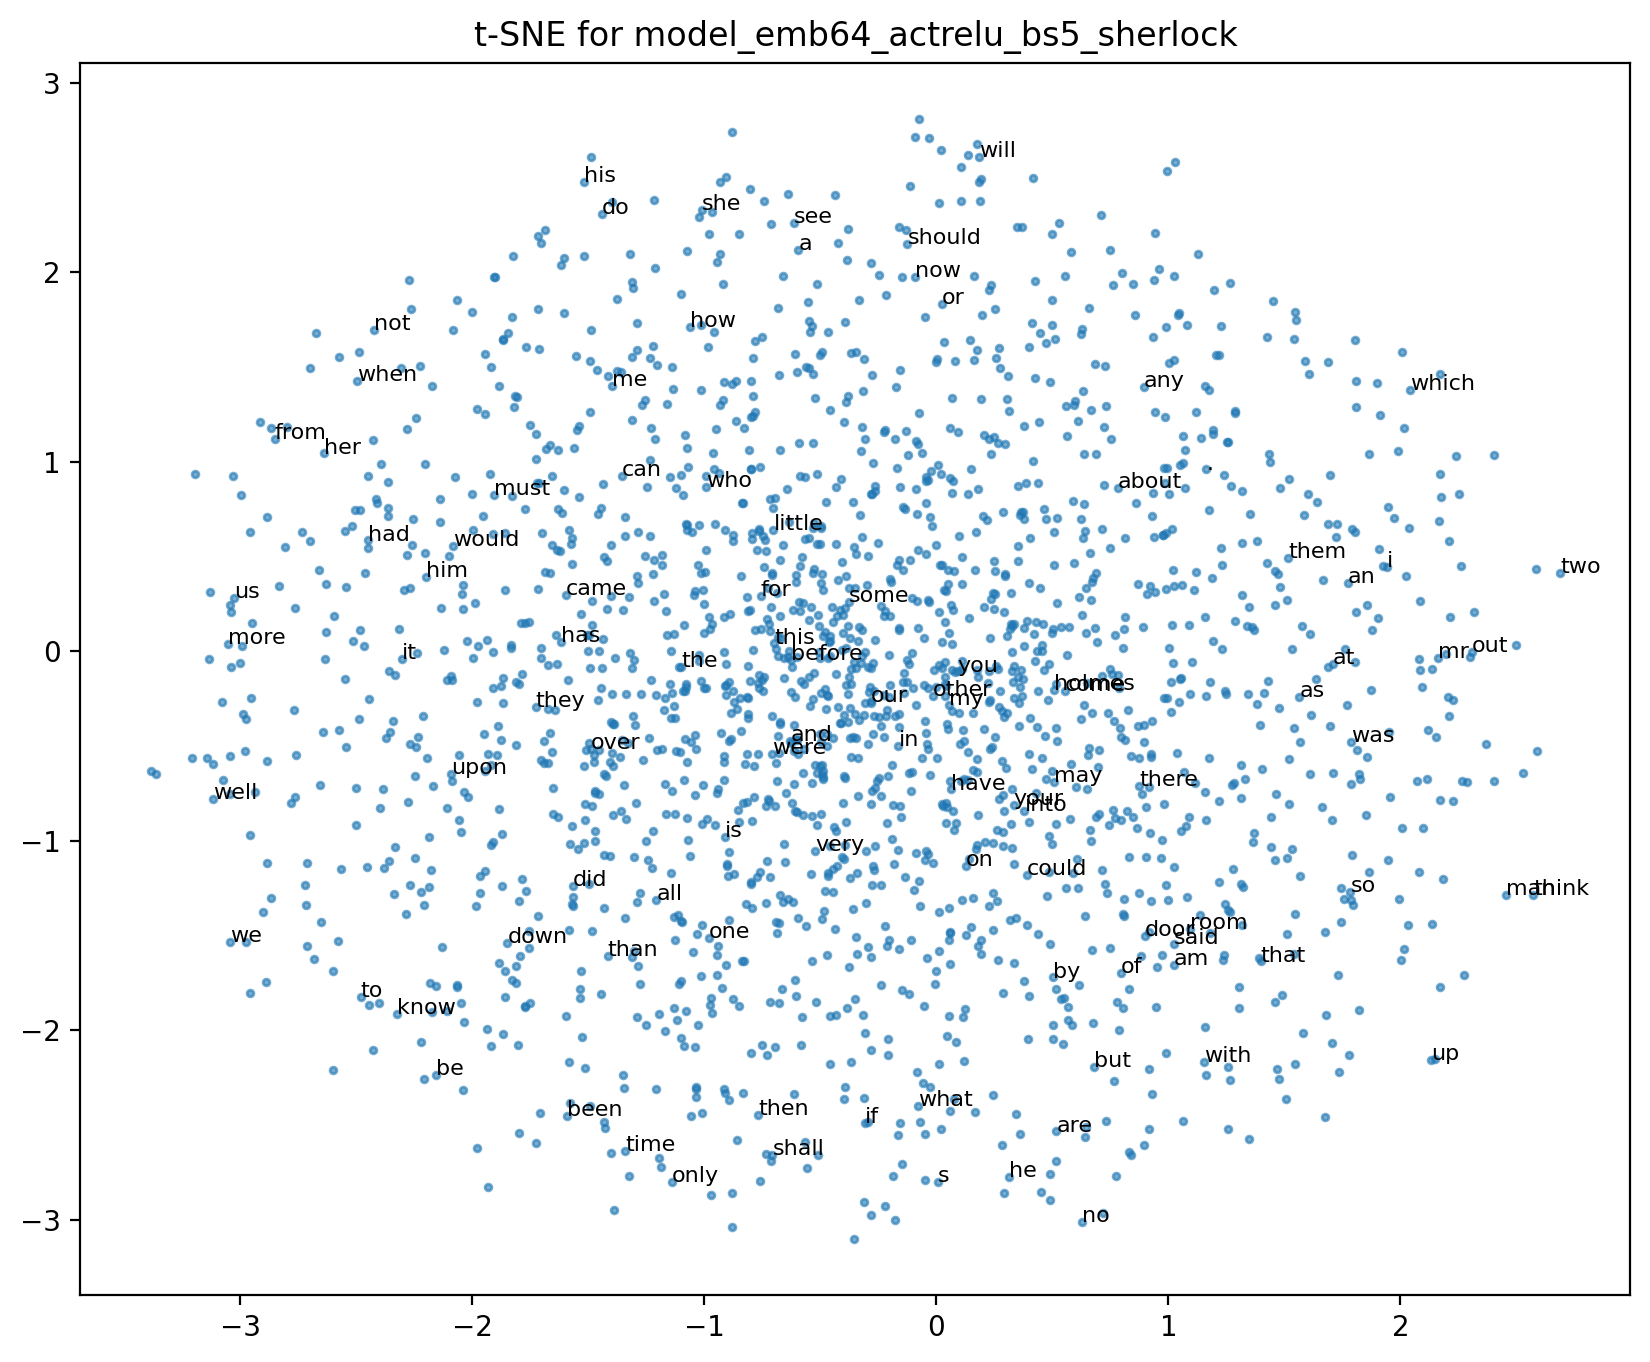


[2/8] Training emb_dim=32, activation=relu, block_size=3
Epoch 1/200 - Train 9.0268 | Val 8.6713
Epoch 2/200 - Train 8.6664 | Val 8.1426
Epoch 3/200 - Train 8.1302 | Val 7.4148
Epoch 10/200 - Train 6.5077 | Val 6.5059
Epoch 20/200 - Train 6.1480 | Val 6.3396
Epoch 30/200 - Train 5.9493 | Val 6.1987
Epoch 40/200 - Train 5.7068 | Val 6.1029
Epoch 50/200 - Train 5.4347 | Val 6.0525
Epoch 60/200 - Train 5.1375 | Val 6.0646
Epoch 70/200 - Train 4.8038 | Val 6.1453
Epoch 80/200 - Train 4.4458 | Val 6.3294
Epoch 90/200 - Train 4.1075 | Val 6.5838
Epoch 100/200 - Train 3.8242 | Val 6.8576
Epoch 110/200 - Train 3.5932 | Val 7.1317
Epoch 120/200 - Train 3.4006 | Val 7.3954
Epoch 130/200 - Train 3.2343 | Val 7.6524
Epoch 140/200 - Train 3.0969 | Val 7.9038
Epoch 150/200 - Train 2.9687 | Val 8.1255
Epoch 160/200 - Train 2.8505 | Val 8.3600
Epoch 170/200 - Train 2.7419 | Val 8.6004
Epoch 180/200 - Train 2.6478 | Val 8.8199
Epoch 190/200 - Train 2.5522 | Val 9.0342
Epoch 200/200 - Train 2.4607 | Va

In [ ]:
# Hyperparameter Grid and Training Loop: 
emb_dims = [32, 64]
activations = ['relu', 'tanh']
block_sizes = [3, 5]
hidden_sizes = [1024, 1024]

# Putting the detailed model first:
configs = [(64, 'relu', 5)] + [
    (e, a, b) for e in emb_dims for a in activations for b in block_sizes
    if not (e == 64 and a == 'relu' and b == 5)
]

# Training Loop:
for i, (emb_dim, activation, block_size) in enumerate(configs, start=1):
    print("\n" + "="*80)
    print(f"[{i}/{len(configs)}] Training emb_dim={emb_dim}, activation={activation}, block_size={block_size}")

    X, Y = sliding_context(tokens_to_ids(tokens, stoi), block_size)
    epochs = 500 if i == 1 else 200

    model, hist = train_model(X, Y, itos, block_size, emb_dim, activation, epochs=epochs)

    model_name = f"model_emb{emb_dim}_act{activation}_bs{block_size}_sherlock"
    torch.save(model.state_dict(), f"{model_name}.pt")
    with open(f"{model_name}_vocab.pkl", "wb") as f: pickle.dump((stoi, itos), f)
    meta = {
        "block_size": block_size, "emb_dim": emb_dim,
        "hidden_sizes": hidden_sizes, "activation": activation,
        "epochs": epochs, "dataset": "sherlock"
    }
    with open(f"{model_name}.json", "w") as f: json.dump(meta, f, indent=4)
    print(f"Saved files for {model_name}")

    if i == 1:  # full visualization for first model
        plt.figure(figsize=(6,4))
        plt.plot(hist['train_loss'], label='train')
        plt.plot(hist['val_loss'], label='val')
        plt.xlabel("Epoch"); plt.ylabel("Loss")
        plt.title(f"Loss curve: {model_name}")
        plt.legend(); plt.show()

        acc = compute_accuracy(model, X, Y)
        print(f"Training accuracy: {acc:.4f}")

        for temp in [0.3, 0.8, 1.2]:
            print(f"\nTemperature {temp}:")
            print(generate_from_prompt(model, itos, stoi, "Sherlock Holmes", block_size, 40, temp))

        plot_tsne_for_model(model, itos, title=f"t-SNE for {model_name}")
